In [93]:
import pandas as pd
import numpy as np
import joblib
from sklearn.inspection import PartialDependenceDisplay
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

pd.options.display.max_seq_items = 2000

# import python modules
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/tabea/Documents/UrbanMobility/src')
from models import random_forest_model as model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Feature Attribution and Interpretability

### Data & Model Loading

In [2]:
journey_17 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2017.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_18 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2018.csv', parse_dates=['end_date', 'start_date'], index_col=0)
journey_19 = pd.read_csv('../data/processed/aggregated_journey_data/agg_journey_data_2019.csv', parse_dates=['end_date', 'start_date'], index_col=0)

In [3]:
journey_train = pd.concat([journey_17, journey_18])
journey_test = journey_19.copy()

In [4]:
x_train, y_train, x_test, y_test = model.train_test_split(journey_train, journey_test)

In [12]:
x_test.shape

(101887, 104)

In [ ]:
rf = joblib.load('../models.random_forest.pkl')

In [5]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [6]:
# evaluation metrics
rmse, mae, r2 = model.evaluation_metrics(y_test, y_pred)

print('RMSE:', rmse)
print('MAE:', mae)
print('R2 Score:', r2)

RMSE: 53.730455204316776
MAE: 26.520372226093613
R2 Score: 0.8500310964005207


### 1. Built in Feature Importance of Tree Models

In [7]:
# feature importance
print(model.get_feature_importance(rf, x_train).to_string())

                                       Feature  Importance
1                                         hour    0.379029
7                                 day_of_month    0.073924
3                                  part_of_day    0.058305
19                         bike_station_counts    0.042386
20                           bike_docks_counts    0.041708
74               residence_lengh_uk_born_ratio    0.026740
0                                  day_of_week    0.026707
34                     ethnic_arab_other_ratio    0.026454
56                         crime_offences_rate    0.025747
8                                  day_of_year    0.024865
37                     religion_buddhist_ratio    0.023820
12                                    humidity    0.023573
10                                   feelslike    0.022606
9                                         temp    0.020387
48                              health_1_ratio    0.019677
103                  start_borough_Westminster    0.0192

### 2. Accumulated Local Effects Plot

In [35]:
from alibi.explainers import ALE, plot_ale
import matplotlib.pyplot as plt

feature_names = x_train.columns

ale = ALE(rf.predict, feature_names=feature_names, target_names=['demand'])

In [30]:
x_test_np = x_test.values

# Convert feature names to indices
feature_indices = [list(x_test.columns).index(name) for name in feature_names]


In [36]:
rf_exp = ale.explain(x_test.values)

/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/tabea/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/User

In [90]:
import numpy as np

def ale_plot(selected_features, height, spacing, title):

    # Convert the feature names to indices
    selected_feature_indices = [list(x_test.columns).index(name) for name in selected_features]

    nrows = int(np.ceil(len(selected_features) / 6))
    ncols = 6

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, height))

    # Flatten the axes array in case it's 2D (when you have more than one row)
    axs = axs.flatten()

    for ax, feature_index in zip(axs, selected_feature_indices):
        plot_ale(rf_exp, features=[feature_index], ax=ax)

        # set another y-axis scale for hour feature
        if feature_index in [1, 19, 20]:
            ax.set_ylabel('ALE (large scale!)')
            ax.set_ylim([-130,130])
        else:
            ax.set_ylim([-31,31])

    # Disable remaining axes
    for ax in axs[len(selected_features):]:
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=spacing)
    plt.suptitle(f'ALE plot for {title}')
    plt.show()


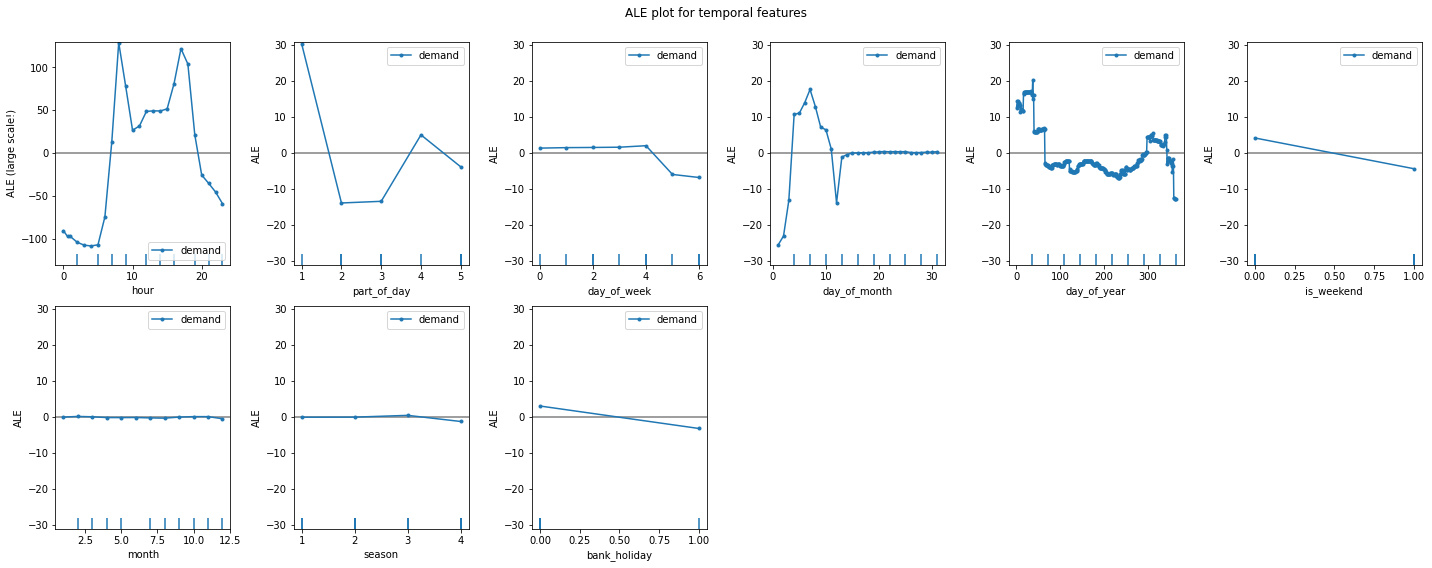

In [91]:
temporal_features = ['hour', 'part_of_day', 'day_of_week', 'day_of_month', 'day_of_year', 'is_weekend', 'month', 'season', 'bank_holiday']
ale_plot(temporal_features, 8, 0.92, 'temporal features')

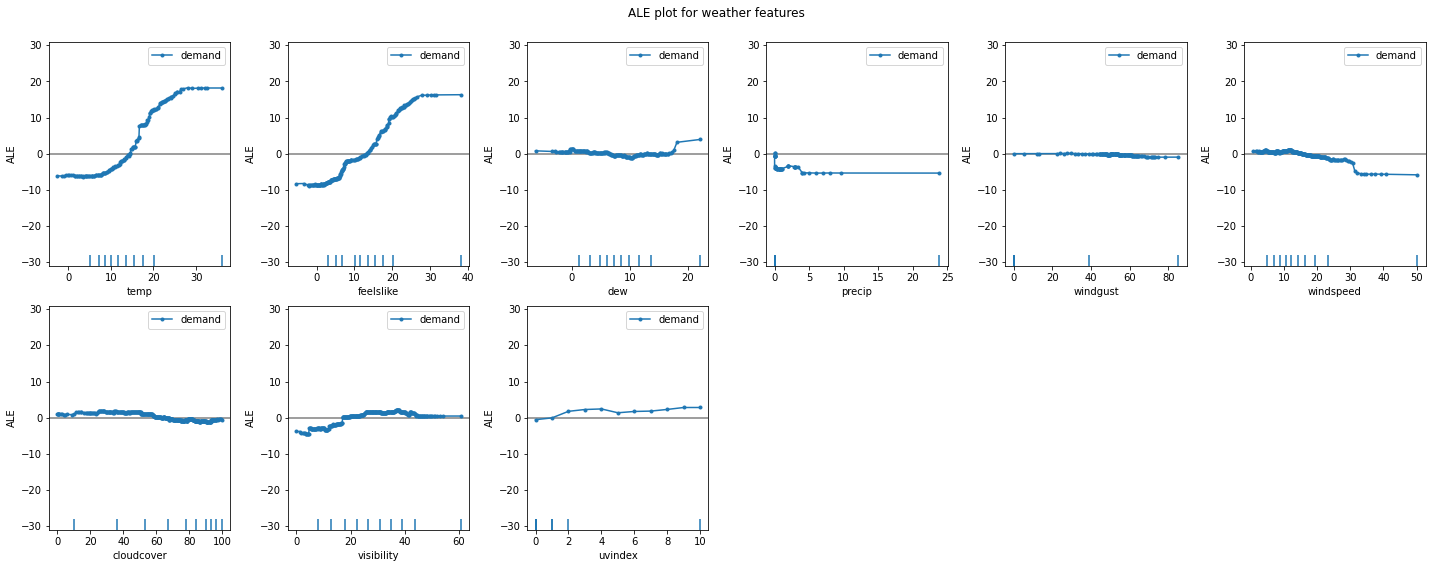

In [78]:
weather_features = ['temp', 'feelslike', 'dew', 'precip', 'windgust', 'windspeed', 'cloudcover', 'visibility', 'uvindex']
ale_plot(weather_features, 8, 0.92, 'weather features')

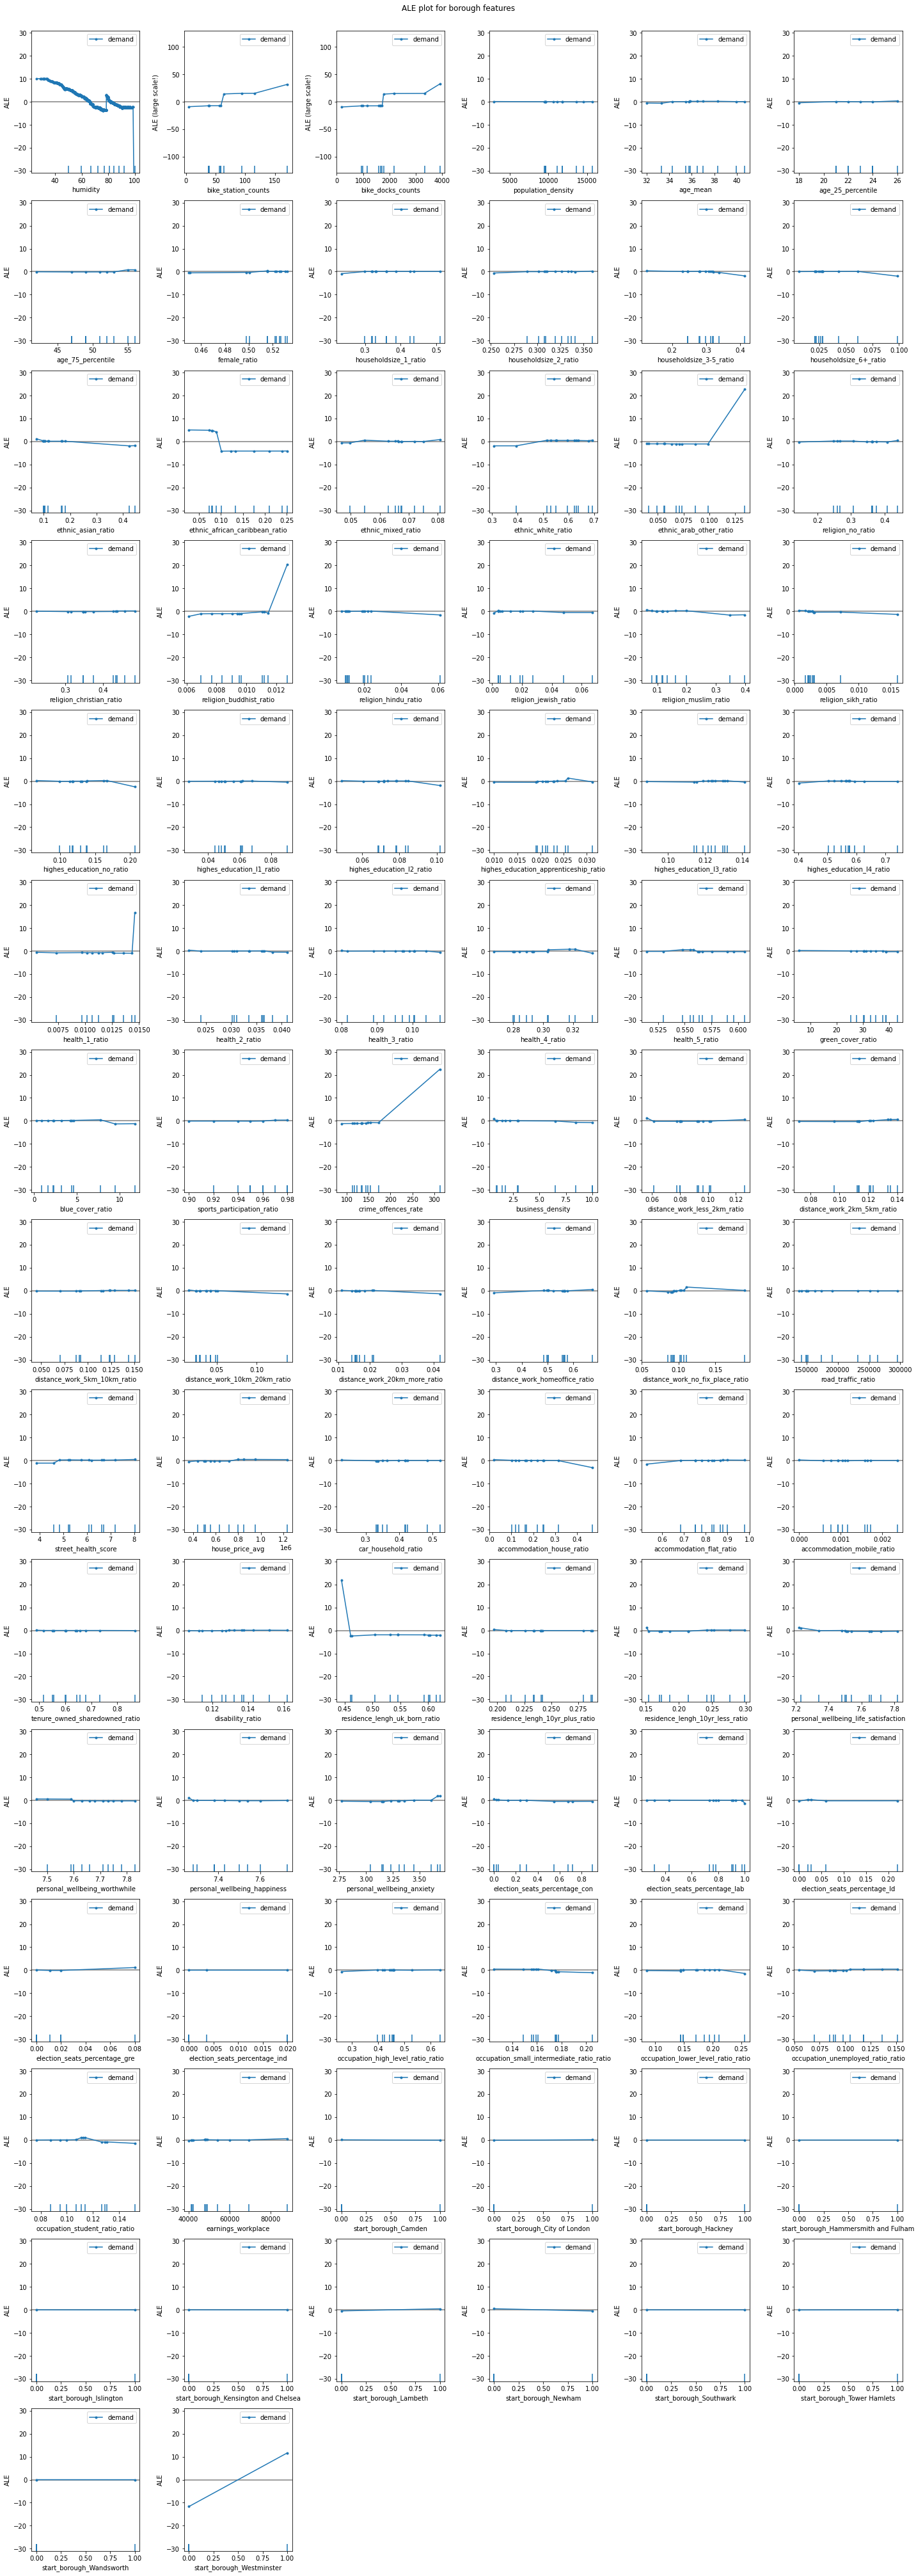

In [92]:
borough_features = x_test.columns[~x_test.columns.isin(temporal_features) & ~x_test.columns.isin(weather_features)]
ale_plot(borough_features, 57, 0.97, 'borough features')

In [ ]:
# Comparing ALE for Random Forest and Gradient Boosting for all the features

### 3. Permutation Feature Importance

In [ ]:
from sklearn.inspection import permutation_importance

# Compute permutation feature importance
permutation = permutation_importance(rf, x_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
perm_importance = permutation.importances_mean

In [ ]:
# summarize feature importance
for i, name in enumerate(x_test.columns):
    print(f"Feature: {name}, Score: {perm_importance[i]}")

### 4. Shapley Additive Explanations (SHAP)

In [95]:
import shap

# Create the explainer
explainer = shap.TreeExplainer(rf)
expected_value = explainer.expected_value

# Compute SHAP values
shap_values = explainer.shap_values(x_test)

In [ ]:
import pickle

filename_expl = '../models/shap_explainer.sav'
pickle.dump(explainer, open(filename_expl, 'wb'))

In [ ]:
filename = '../models/shap_values.sav'
pickle.dump(shap_values, open(filename, 'wb'))

In [ ]:

load_shap_values = pickle.load(open(filename, 'rb'))
print(load_shap_values)```

load_explainer = pickle.load(open(filename_expl, 'rb'))
print(load_explainer)


In [ ]:
# standard summary
shap.summary_plot(shap_values, x_test)

In [ ]:
# beeswarm summary
shap.plots.beeswarm(shap_values)

In [ ]:
# waterfall
shap.plots.waterfall(shap_values[0])

In [ ]:
# bar plot
shap.plots.bar(shap_values, max_display=12)

In [ ]:
# heatmap
shap.plots.heatmap(shap_values)

In [ ]:
# cohort plot -> multiple-bar plot: one for each borough
sex = ["Women" if shap_values[i,"Sex"].data == 0 else "Men" for i in range(shap_values.shape[0])]
shap.plots.bar(shap_values.cohorts(sex).abs.mean(0))

shap.plots.bar(shap_values.cohorts(2).abs.mean(0))

In [ ]:
# identify outliers
y_pred = model.predict(X_test)  # Get predictions on the probability scale.
T = X_test[(y_pred >= 0.03) & (y_pred <= 0.1)]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[1]
r = shap.decision_plot(expected_value, sh, T, feature_order='hclust', return_objects=True)

# Find the two observations with the most negative 'Age' SHAP values.
idx = np.argpartition(sh[:, T.columns.get_loc('Age')], 2)[0:2]

# Plot the observations individually with their corresponding feature values. The plots use the same feature order
# as the original plot.
for i in idx:
    shap.decision_plot(expected_value, sh[i], X_display.loc[T.index[i]], feature_order=r.feature_idx, xlim=r.xlim)

In [ ]:
# identify typical prediction paths
y_pred = model.predict(X_test)  # Get predictions on the probability scale.
T = X_test[y_pred >= 0.98]
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[1]
shap.decision_plot(expected_value, sh, T, feature_order='hclust', link='logit')

In [ ]:
# decision of one single observation
shap.decision_plot(a, b, c, feature_display_range=slice(None, -31, -1))